Author
--------
Hamidreza Ashrafi	 --	UofC	--	hamidreza.ashrafi@ucalgary.ca

Date
------
March 26, 2022

Code title
------------
Geomatric Control of UAV to follow a given trajectory in the presence of disturbance (wind) (two different cases studied from the 2nd reference provided below) - Extracting position, angular velocity, trusts, attitude error, desired angular velocity, torques and force.

References
--------------

[1] Lee, T., Leok, M. and McClamroch, N.H., 2010, December. Geometric tracking control of a quadrotor UAV on SE (3). In 49th IEEE conference on decision and control (CDC) (pp. 5420-5425). IEEE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import interpolate

# Constant Parameters

In [2]:
m = 4.34
d = .315
g = 9.8
C_Tf = 8.004*1e-4
k_x = 16*m
k_v = 5.6*m
k_R = 8.81
k_omega = 2.54
J = np.diag([.082,.0845,.1377])
C_d = .01

# UAV function

In [3]:
def Quadrotor(t, s):
    
    #Current States
    
    x = np.array([s[0], s[1], s[2]])
    v = np.array([s[3], s[4], s[5]])
    R = np.array([[s[6], s[9], s[12]], 
                  [s[7], s[10], s[13]],
                  [s[8], s[11], s[14]]])
    omega = np.array([s[15], s[16], s[17]])

    omega_hat = np.array([[0, -omega[2], omega[1]],
                         [omega[2], 0, -omega[0]],
                         [-omega[1], omega[0], 0]])
    Rdot = R @ omega_hat
    
    
    # Disturbance Force
    
    v_w = np.array([np.sin(2*t) + np.cos(4*t), np.cos(3*t), -.5])
    F_d= - C_d * np.linalg.norm(v - v_w)*(v - v_w)
    

    # Position Error

    e_x = x - x_d(t)
    e_v = v - xdot_d(t)
    
    # A & f & f1

    A = -k_x*e_x - k_v*e_v - m*g*np.array([0., 0, 1]) + m*xdot2_d(t)
    f = -A@R@np.array([0., 0, 1])
    f1 = -A

    # Desired Rotation Matrix & Angular Velocity + Derivatives

    # First and second derivative of e_v:
    edot_v = g*np.array([0, 0., 1]) - f * R @ np.array([0, 0, 1])/m - xdot2_d(t) 
    fdot = (k_x*e_v + k_v*edot_v - m*xdot3_d(t)) @ R[:,2] + f1 @ Rdot[:,2]
    edot2_v = (-fdot * R[:,2] - f * Rdot[:,2] - m*xdot3_d(t))/m

    # b_3 vector:
    Adot = -k_x*e_v - k_v*edot_v + m*xdot3_d(t)
    Adot2 = -k_x*edot_v - k_v*edot2_v + m*xdot4_d(t)
    b_3c = -A/np.linalg.norm(A)

    # b_2 vector
    C = np.cross(b_1d(t), b_3c)
    n_C = np.linalg.norm(C)
    b_2c = -C/n_C

    # b_1 vector:
    b_1c = np.cross(b_2c, b_3c)

    # Desired R:
    R_c = np.concatenate((b_1c.reshape((3,1)), b_2c.reshape((3,1)), b_3c.reshape((3,1))), axis=1)

    # Derivative of b_3:
    n_A = np.linalg.norm(A)
    bdot_3c = -(Adot/n_A) + (A * (Adot.T @ A))/(n_A**3)

    # Derivative of b_2:
    Cdot = np.cross(b_1d(t), bdot_3c)+ np.cross(bdot_1d(t) ,b_3c)
    bdot_2c = -(Cdot/n_C) + (C * (Cdot.T @ C)) / (n_C**3)

    # Derivative of b_1:
    bdot_1c = np.cross(bdot_2c, b_3c) + np.cross(b_2c, bdot_3c)

    # Derivative of desired R:
    Rdot_c = np.concatenate((bdot_1c.reshape((3,1)), bdot_2c.reshape((3,1)), bdot_3c.reshape((3,1))), axis=1)  

    # Second derivative of b_3:
    E0 = -Adot2/n_A
    E1 = 2*(A.T @ Adot) * Adot/(n_A**3)
    E2 = (np.linalg.norm(Adot)**2 + A.T @ Adot2) * A/(n_A**3)
    E3 = -3*(A.T @ Adot)**2 * A/(n_A**5)
    bdot2_3c = E0 + E1 + E2 + E3

    # Second derivative of b_2:
    Cdot2 = np.cross(b_1d(t), bdot2_3c) + 2*np.cross(bdot_1d(t), bdot_3c) + np.cross(bdot2_1d(t), b_3c)
    E0 = -Cdot2/n_C
    E1 = 2*(C.T @ Cdot) * Cdot/(n_C**3)
    E2 = (np.linalg.norm(Cdot)**2 + C.T @ Cdot2) * C/(n_C**3)
    E3 = -3*(C.T @ Cdot)**2 * C/(n_C**5)
    bdot2_2c = E0 + E1 + E2 + E3

    # Second derivative of b_1:
    bdot2_1c = np.cross(bdot2_2c, b_3c) + 2*np.cross(bdot_2c, bdot_3c) + np.cross(b_2c, bdot2_3c)

    # Second derivative of commanded R:
    Rdot2_c = np.concatenate((bdot2_1c.reshape((3,1)), bdot2_2c.reshape((3,1)), bdot2_3c.reshape((3,1))), axis=1) 

    # omega_c:
    omega_c_before_vee = R_c.T @ Rdot_c
    omega_c = np.array([omega_c_before_vee[2,1],omega_c_before_vee[0,2],omega_c_before_vee[1,0]]) 

    # omegadot_c:
    omega_c_hat = omega_c_before_vee
    omegadot_c_before_vee = R_c.T @ Rdot2_c - np.linalg.matrix_power(omega_c_hat,2)
    omegadot_c = np.array([omegadot_c_before_vee[2,1],omegadot_c_before_vee[0,2],omegadot_c_before_vee[1,0]])

    # Rotational Error 

    e_R_before_vee = .5*(R_c.T @ R - R.T @ R_c)
    e_R = np.array([e_R_before_vee[2,1], e_R_before_vee[0,2], e_R_before_vee[1,0]])
    e_omega = omega - R.T @ R_c @ omega_c

    # Controller

    # f= -A.T @ R @ np.array([[0], [0], [1]]) computed
    M = -k_R * e_R - k_omega * e_omega + np.cross(omega,(J @ omega)) - J @ (omega_hat @ R.T @ R_c @ omega_c - R.T @ R_c @ omegadot_c)

    # Rotor Controller!!

    Tmat = np.array([[1, 1 , 1, 1],
                     [0, -d, 0, d],
                     [d, 0, -d, 0],
                     [-C_Tf, C_Tf, -C_Tf, C_Tf]])

    T = np.linalg.inv(Tmat) @ np.array([f, M[0], M[1], M[2]])
    

    # System Dynamics
    
    U_e = m*g*np.array([0, 0., 1]) - f * R @ np.array([0, 0., 1]) + F_d
    M_e = M
    vdot = U_e/m
    Rdot = R @ omega_hat
    omegadot = np.linalg.inv(J) @ (M_e - (np.cross(omega, (J@omega))))
    y = [v[0], v[1], v[2], vdot[0], vdot[1], vdot[2], Rdot[0,0],
         Rdot[1,0],Rdot[2,0],Rdot[0,1],Rdot[1,1],Rdot[2,1],Rdot[0,2],Rdot[1,2],Rdot[2,2],
         omegadot[0],omegadot[1],omegadot[2]];

    return y

# Function to generate trusts, attitude error, torques, force, desired omega

In [4]:
def fgen(t, s):
    
    x = np.array([s[0], s[1], s[2]])
    v = np.array([s[3], s[4], s[5]])
    R = np.array([[s[6], s[9], s[12]], 
                  [s[7], s[10], s[13]],
                  [s[8], s[11], s[14]]])
    omega = np.array([s[15], s[16], s[17]])

    omega_hat = np.array([[0, -omega[2], omega[1]],
                         [omega[2], 0, -omega[0]],
                         [-omega[1], omega[0], 0]])
    Rdot = R @ omega_hat
    
    # Disturbance Force
    
    v_w = np.array([np.sin(2*t) + np.cos(4*t), np.cos(3*t), -.5])
    F_d = - C_d * np.linalg.norm(v - v_w)*(v - v_w)

    # Position Error

    e_x = x - x_d(t)
    e_v = v - xdot_d(t)
    
    # A & f & f1

    A = -k_x*e_x - k_v*e_v - m*g*np.array([0., 0, 1]) + m*xdot2_d(t)
    f = -A@R@np.array([0., 0, 1])
    f1 = -A

    # Desired Rotation Matrix & Angular Velocity + Derivatives

    # First and second derivative of e_v:
    edot_v = g*np.array([0, 0., 1]) - f * R @ np.array([0, 0, 1])/m - xdot2_d(t) 
    fdot = (k_x*e_v + k_v*edot_v - m*xdot3_d(t)) @ R[:,2] + f1 @ Rdot[:,2]
    edot2_v = (-fdot * R[:,2] - f * Rdot[:,2] - m*xdot3_d(t))/m

    # b_3 vector:
    Adot = -k_x*e_v - k_v*edot_v + m*xdot3_d(t)
    Adot2 = -k_x*edot_v - k_v*edot2_v + m*xdot4_d(t)
    b_3c = -A/np.linalg.norm(A)

    # b_2 vector
    C = np.cross(b_1d(t), b_3c)
    n_C = np.linalg.norm(C)
    b_2c = -C/n_C

    # b_1 vector:
    b_1c = np.cross(b_2c, b_3c)

    # Desired R:
    R_c = np.concatenate((b_1c.reshape((3,1)), b_2c.reshape((3,1)), b_3c.reshape((3,1))), axis=1)

    # Derivative of b_3:
    n_A = np.linalg.norm(A)
    bdot_3c = -(Adot/n_A) + (A * (Adot.T @ A))/(n_A**3)

    # Derivative of b_2:
    Cdot = np.cross(b_1d(t), bdot_3c)+ np.cross(bdot_1d(t) ,b_3c)
    bdot_2c = -(Cdot/n_C) + (C * (Cdot.T @ C)) / (n_C**3)

    # Derivative of b_1:
    bdot_1c = np.cross(bdot_2c, b_3c) + np.cross(b_2c, bdot_3c)

    # Derivative of desired R:
    Rdot_c = np.concatenate((bdot_1c.reshape((3,1)), bdot_2c.reshape((3,1)), bdot_3c.reshape((3,1))), axis=1)  

    # Second derivative of b_3:
    E0 = -Adot2/n_A
    E1 = 2*(A.T @ Adot) * Adot/(n_A**3)
    E2 = (np.linalg.norm(Adot)**2 + A.T @ Adot2) * A/(n_A**3)
    E3 = -3*(A.T @ Adot)**2 * A/(n_A**5)
    bdot2_3c = E0 + E1 + E2 + E3

    # Second derivative of b_2:
    Cdot2 = np.cross(b_1d(t), bdot2_3c) + 2*np.cross(bdot_1d(t), bdot_3c) + np.cross(bdot2_1d(t), b_3c)
    E0 = -Cdot2/n_C
    E1 = 2*(C.T @ Cdot) * Cdot/(n_C**3)
    E2 = (np.linalg.norm(Cdot)**2 + C.T @ Cdot2) * C/(n_C**3)
    E3 = -3*(C.T @ Cdot)**2 * C/(n_C**5)
    bdot2_2c = E0 + E1 + E2 + E3

    # Second derivative of b_1:
    bdot2_1c = np.cross(bdot2_2c, b_3c) + 2*np.cross(bdot_2c, bdot_3c) + np.cross(b_2c, bdot2_3c)

    # Second derivative of commanded R:
    Rdot2_c = np.concatenate((bdot2_1c.reshape((3,1)), bdot2_2c.reshape((3,1)), bdot2_3c.reshape((3,1))), axis=1) 

    # omega_c:
    omega_c_before_vee = R_c.T @ Rdot_c
    omega_c = np.array([omega_c_before_vee[2,1],omega_c_before_vee[0,2],omega_c_before_vee[1,0]]) 

    # omegadot_c:
    omega_c_hat = omega_c_before_vee
    omegadot_c_before_vee = R_c.T @ Rdot2_c - np.linalg.matrix_power(omega_c_hat,2)
    omegadot_c = np.array([omegadot_c_before_vee[2,1],omegadot_c_before_vee[0,2],omegadot_c_before_vee[1,0]])

    # Rotational Error 

    e_R_before_vee = .5*(R_c.T @ R - R.T @ R_c)
    e_R = np.array([e_R_before_vee[2,1], e_R_before_vee[0,2], e_R_before_vee[1,0]])
    e_omega = omega - R.T @ R_c @ omega_c

    # Controller

    # f= -A.T @ R @ np.array([[0], [0], [1]]) computed
    M = -k_R * e_R - k_omega * e_omega + np.cross(omega,(J @ omega)) - J @ (omega_hat @ R.T @ R_c @ omega_c - R.T @ R_c @ omegadot_c)

    # Rotor Controller!!

    Tmat = np.array([[1, 1 , 1, 1],
                     [0, -d, 0, d],
                     [d, 0, -d, 0],
                     [-C_Tf, C_Tf, -C_Tf, C_Tf]])

    T = np.linalg.inv(Tmat) @ np.array([f, M[0], M[1], M[2]])
    

    # System Dynamics
    
    U_e = m*g*np.array([0, 0., 1]) - f * R @ np.array([0, 0., 1]) + F_d
    M_e = M
    vdot = U_e/m
    Rdot = R @ omega_hat
    
    # Trusts and Errors 
    
    AttE = 0.5 * np.trace(np.eye(3) - R_c.T@R)
    y = [T[0], T[1], T[2], T[3], f, M_e[0], M_e[1], M_e[2], omega_c[0], omega_c[1], omega_c[2], AttE];

    return y

# Solving ODE of the UAV motion (Case 1)

In [5]:
# Desired Trajectory

def x_d(t):
    return np.array([0.4*t, 0.4*np.sin(np.pi*t), -1*0.6*np.cos(np.pi*t)])

def xdot_d(t):
    return np.array([0.4, np.pi*0.4*np.cos(np.pi*t), -1*-np.pi*0.6*np.sin(np.pi*t)])

def xdot2_d(t):
    return np.array([0, -np.pi**2*0.4*np.sin(np.pi*t), -1*-np.pi**2*0.6*np.cos(np.pi*t)])

def xdot3_d(t):
    return np.array([0, -np.pi**3*0.4*np.cos(np.pi*t), -1*np.pi**3*0.6*np.sin(np.pi*t)])

def xdot4_d(t):
    return np.array([0, np.pi**4*0.4*np.sin(np.pi*t), -1*np.pi**4*0.6*np.cos(np.pi*t)])

########################

def b_1d(t):
    return np.array([np.cos(np.pi*t), np.sin(np.pi*t), 0])

def bdot_1d(t):
    return np.array([-np.pi*np.sin(np.pi*t), np.pi*np.cos(np.pi*t), 0])

def bdot2_1d(t):
    return np.array([-np.pi**2*np.cos(np.pi*t), -np.pi**2*np.sin(np.pi*t), t*0])


# Initial Conditions
x0 = [0, 0, 0] # Initial Position
v0 = [0, 0, 0]  # Initial Velocity
R0 = np.eye(3)   # Initial Rotation Matrix
omega0 = [0, 0, 0]  # Initial Angular Velocity

y0 = [x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], 
 R0[0,0], R0[1,0],R0[2,0],R0[0,1],R0[1,1],R0[2,1],R0[0,2],R0[1,2],R0[2,2],omega0[0],omega0[1],omega0[2]]

end = 10

t_span = (0.0, end)     # Duration: 0 to 10S
tcase1 = np.arange(0.0, end, 0.01)

# Numerical Solution

case1 = solve_ivp(Quadrotor, t_span, y0, t_eval=tcase1)

# Extracting trusts, attitude error, torques, force, desired omega (Case 1)

In [6]:
history = []
for i in range(len(tcase1)):
    (t, *s) = np.concatenate((tcase1.reshape((1,-1)), case1.y), axis=0)[:,i]
    history.append(fgen(t,s))

In [7]:
history = np.array(history)
T1 = history[:,0]
T2 = history[:,1]
T3 = history[:,2]
T4 = history[:,3]
f = history[:,4]
M1 = history[:,5]
M2 = history[:,6]
M3 = history[:,7]
omegax = history[:,8]
omegay = history[:,9]
omegaz = history[:,10]
Rc = history[:,11]

# Plotting position and angular velocity (Case 1)

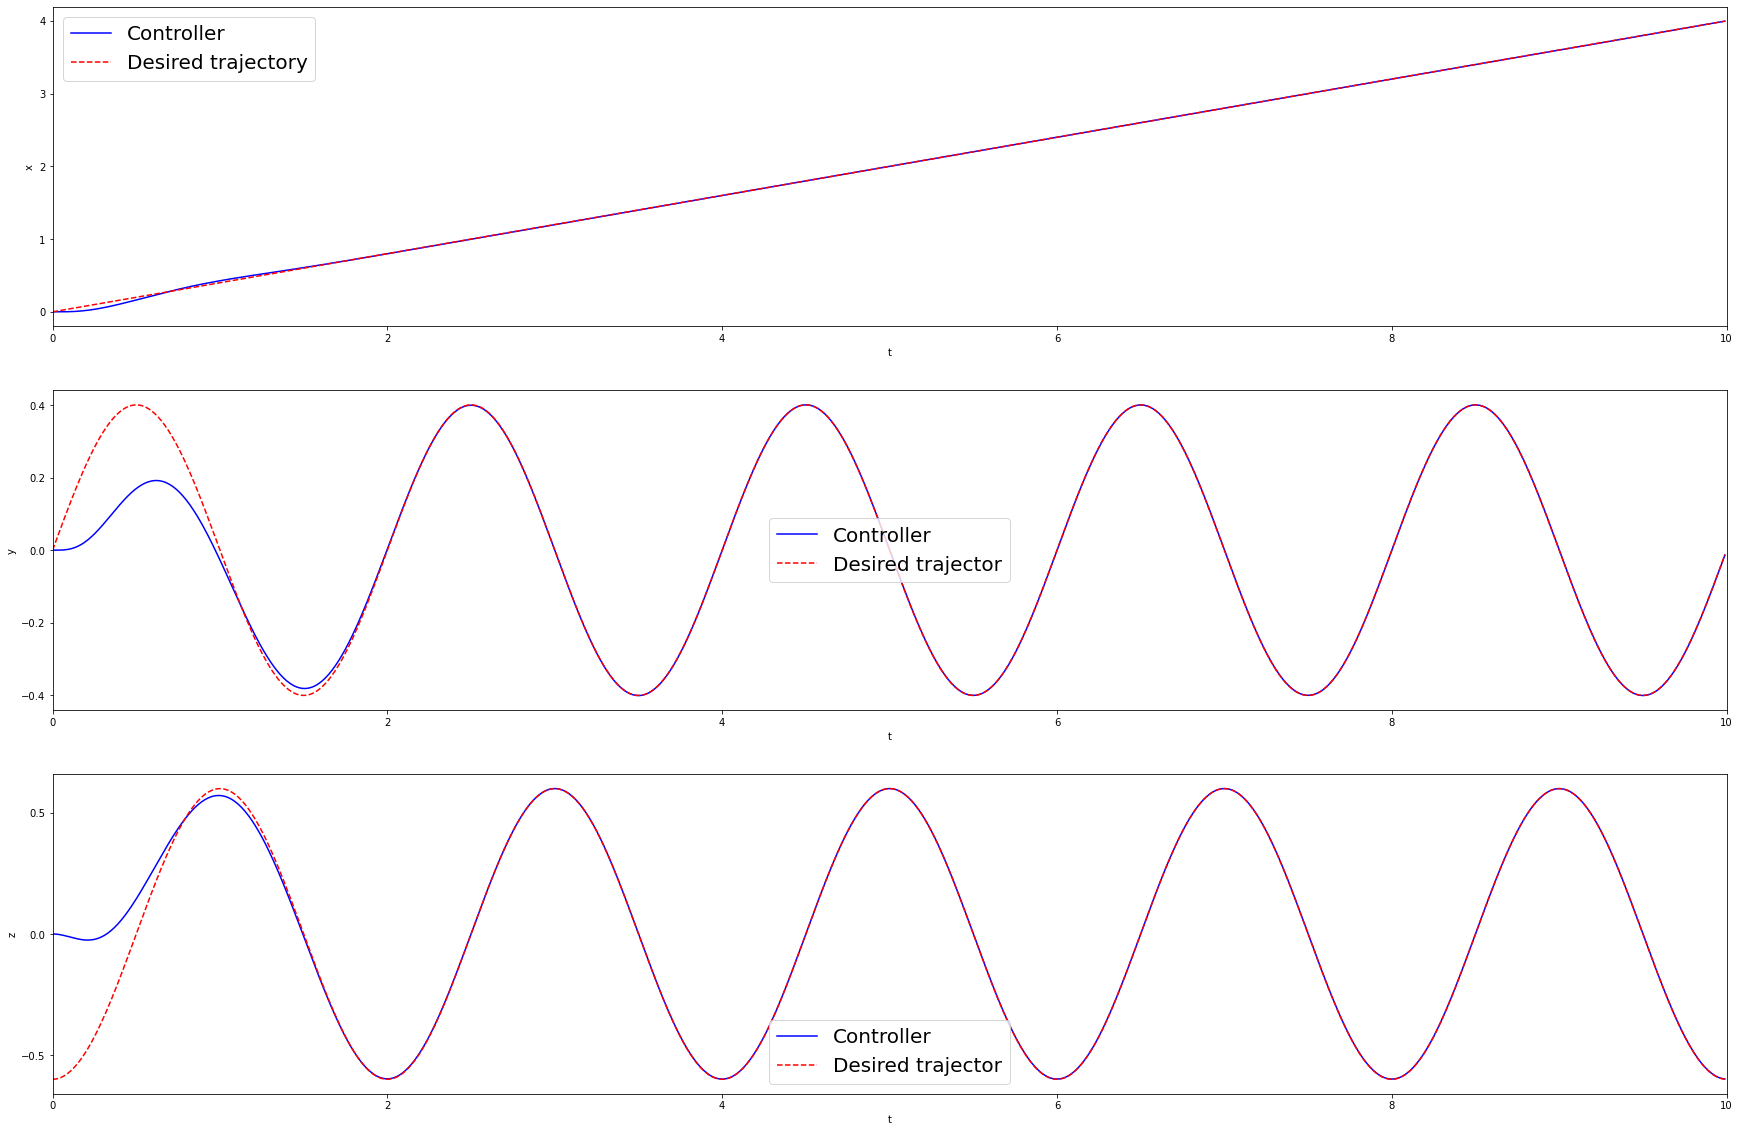

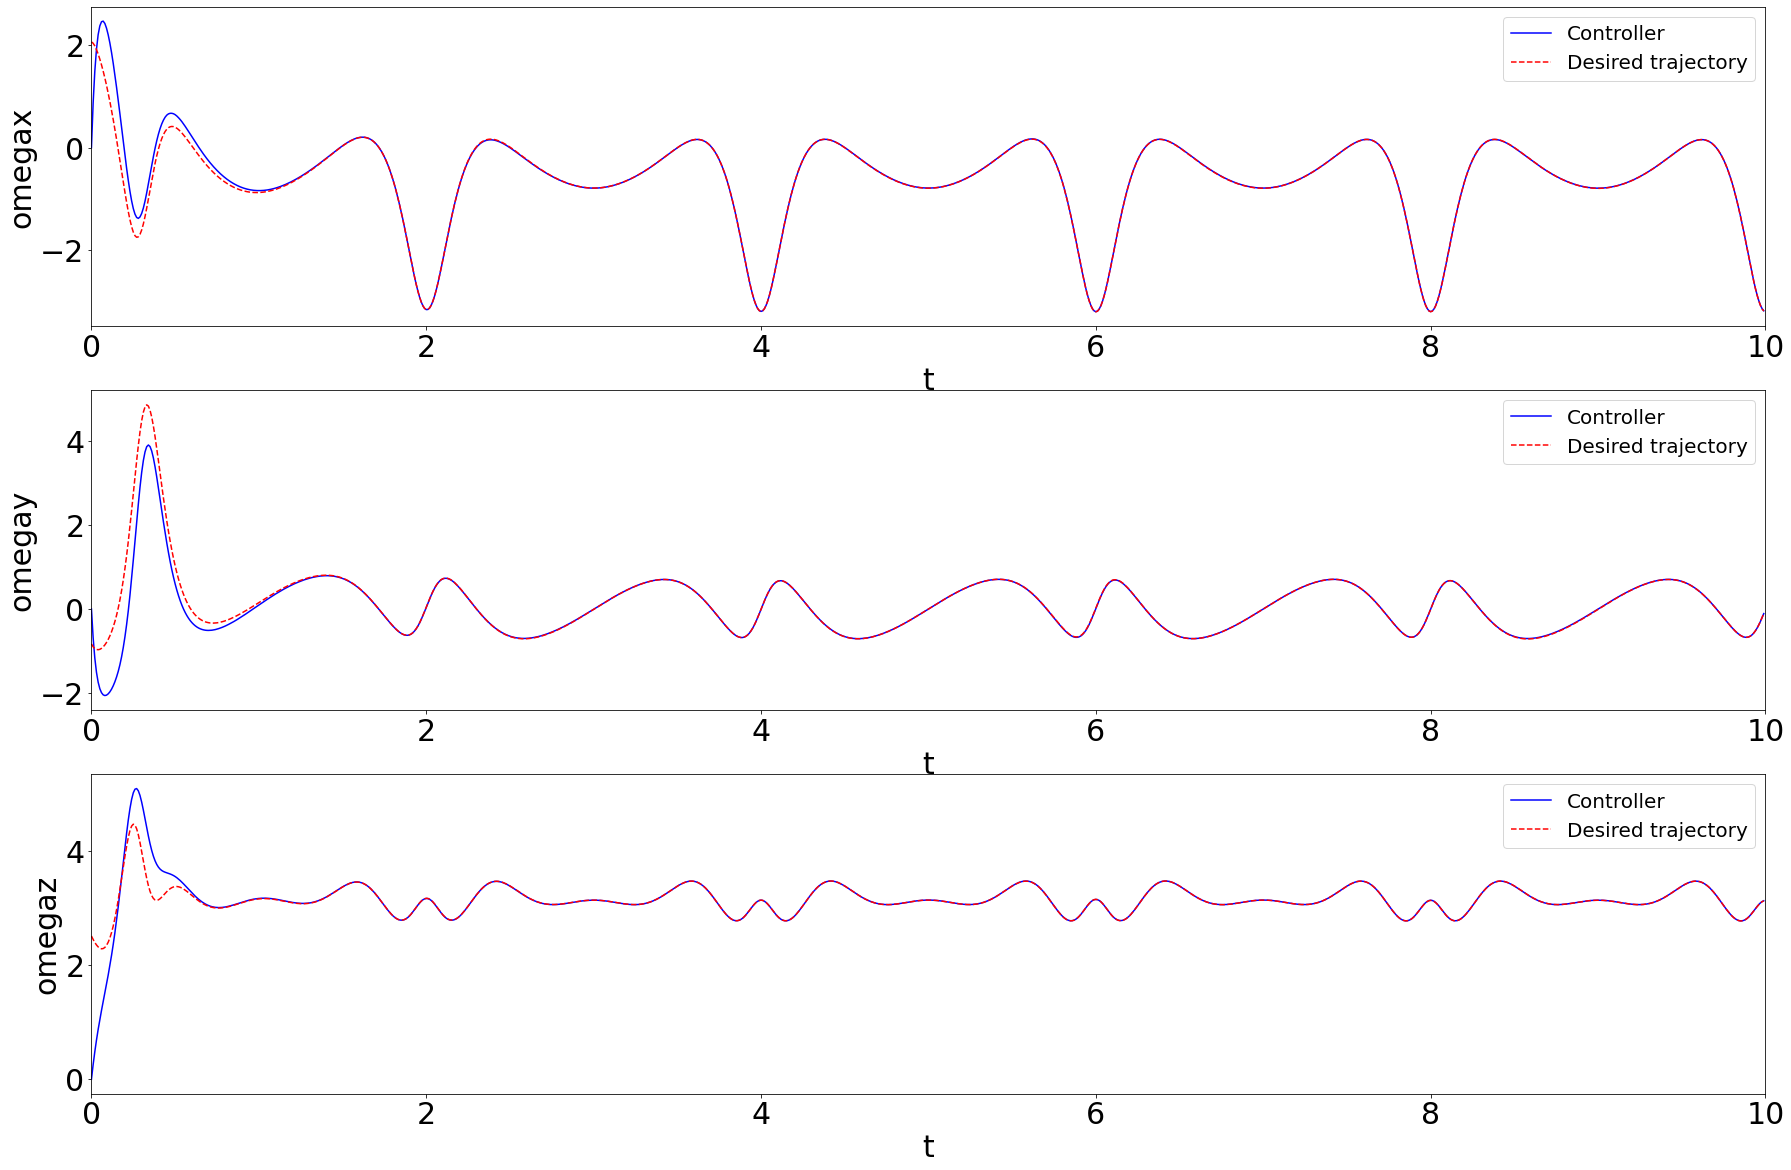

In [8]:
fig, axs = plt.subplots(3, 1,figsize = (12*2.5,8*2.5))

lim = [0, end]

plt.rcParams['font.size'] = '30'

axs[0].plot(tcase1,case1.y[0, :], 'b',label='Controller')
axs[0].plot(tcase1,x_d(tcase1)[0], 'r--',label='Desired trajectory')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_xlim(lim)
axs[0].legend(fontsize=20)



axs[1].plot(tcase1,case1.y[1, :], 'b',label='Controller')
axs[1].plot(tcase1,x_d(tcase1)[1], 'r--',label='Desired trajector')
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')
axs[1].set_xlim(lim)
axs[1].legend(fontsize=20)


axs[2].plot(tcase1,case1.y[2, :], 'b',label='Controller')
axs[2].plot(tcase1,x_d(tcase1)[2], 'r--',label='Desired trajector')
axs[2].set_xlabel('t')
axs[2].set_ylabel('z')
axs[2].set_xlim(lim)
axs[2].legend(fontsize=20)


fig, axs = plt.subplots(3, 1,figsize = (12*2.5,8*2.5))

lim = [0, end]

plt.rcParams['font.size'] = '30'

axs[0].plot(tcase1,case1.y[15, :], 'b',label='Controller')
axs[0].plot(tcase1,omegax, 'r--', label='Desired trajectory')
axs[0].set_xlabel('t')
axs[0].set_ylabel('omegax')
axs[0].set_xlim(lim)
axs[0].legend(fontsize=20)



axs[1].plot(tcase1,case1.y[16, :], 'b',label='Controller')
axs[1].plot(tcase1,omegay, 'r--', label='Desired trajectory')
axs[1].set_xlabel('t')
axs[1].set_ylabel('omegay')
axs[1].set_xlim(lim)
axs[1].legend(fontsize=20)


axs[2].plot(tcase1,case1.y[17, :], 'b',label='Controller')
axs[2].plot(tcase1,omegaz, 'r--', label='Desired trajectory')
axs[2].set_xlabel('t')
axs[2].set_ylabel('omegaz')
axs[2].set_xlim(lim)
axs[2].legend(fontsize=20)

# Plotting trusts and attitude error (Case 1)

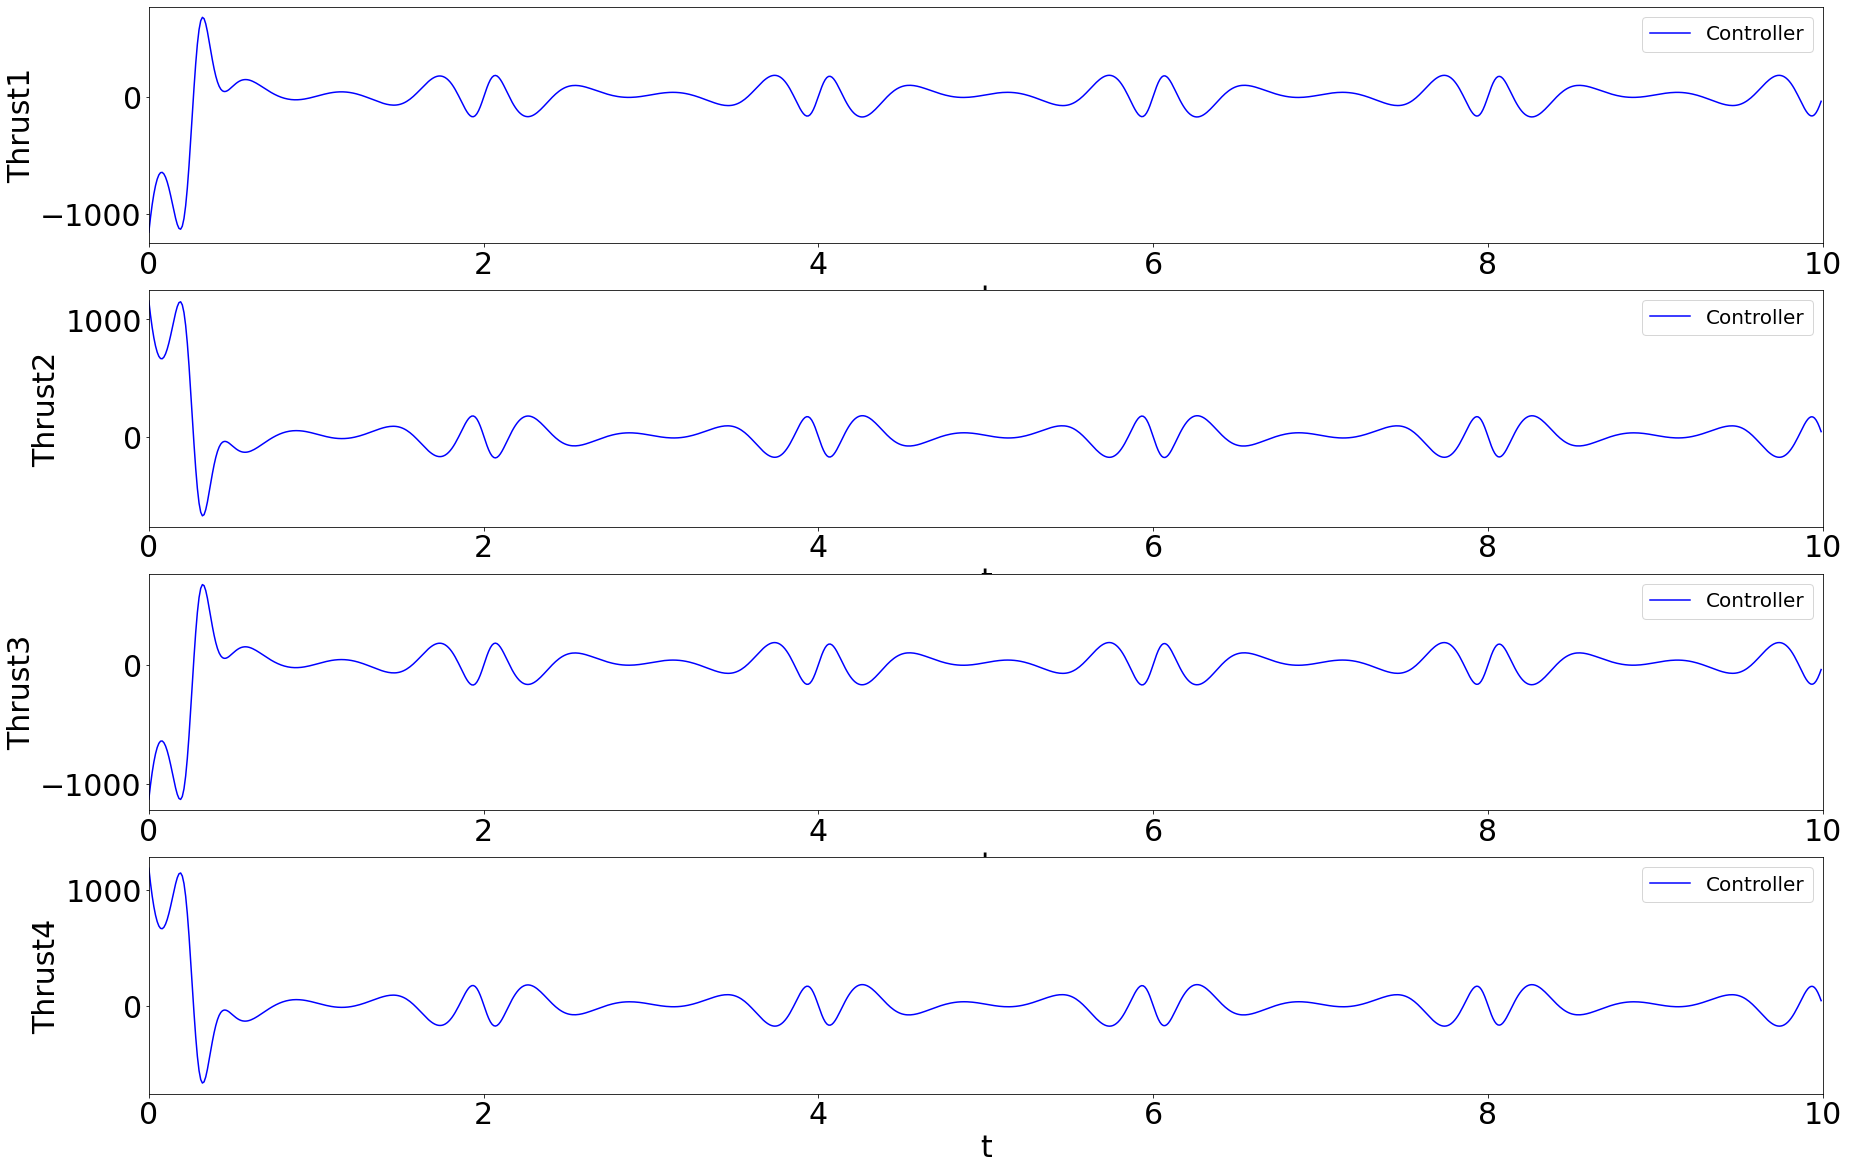

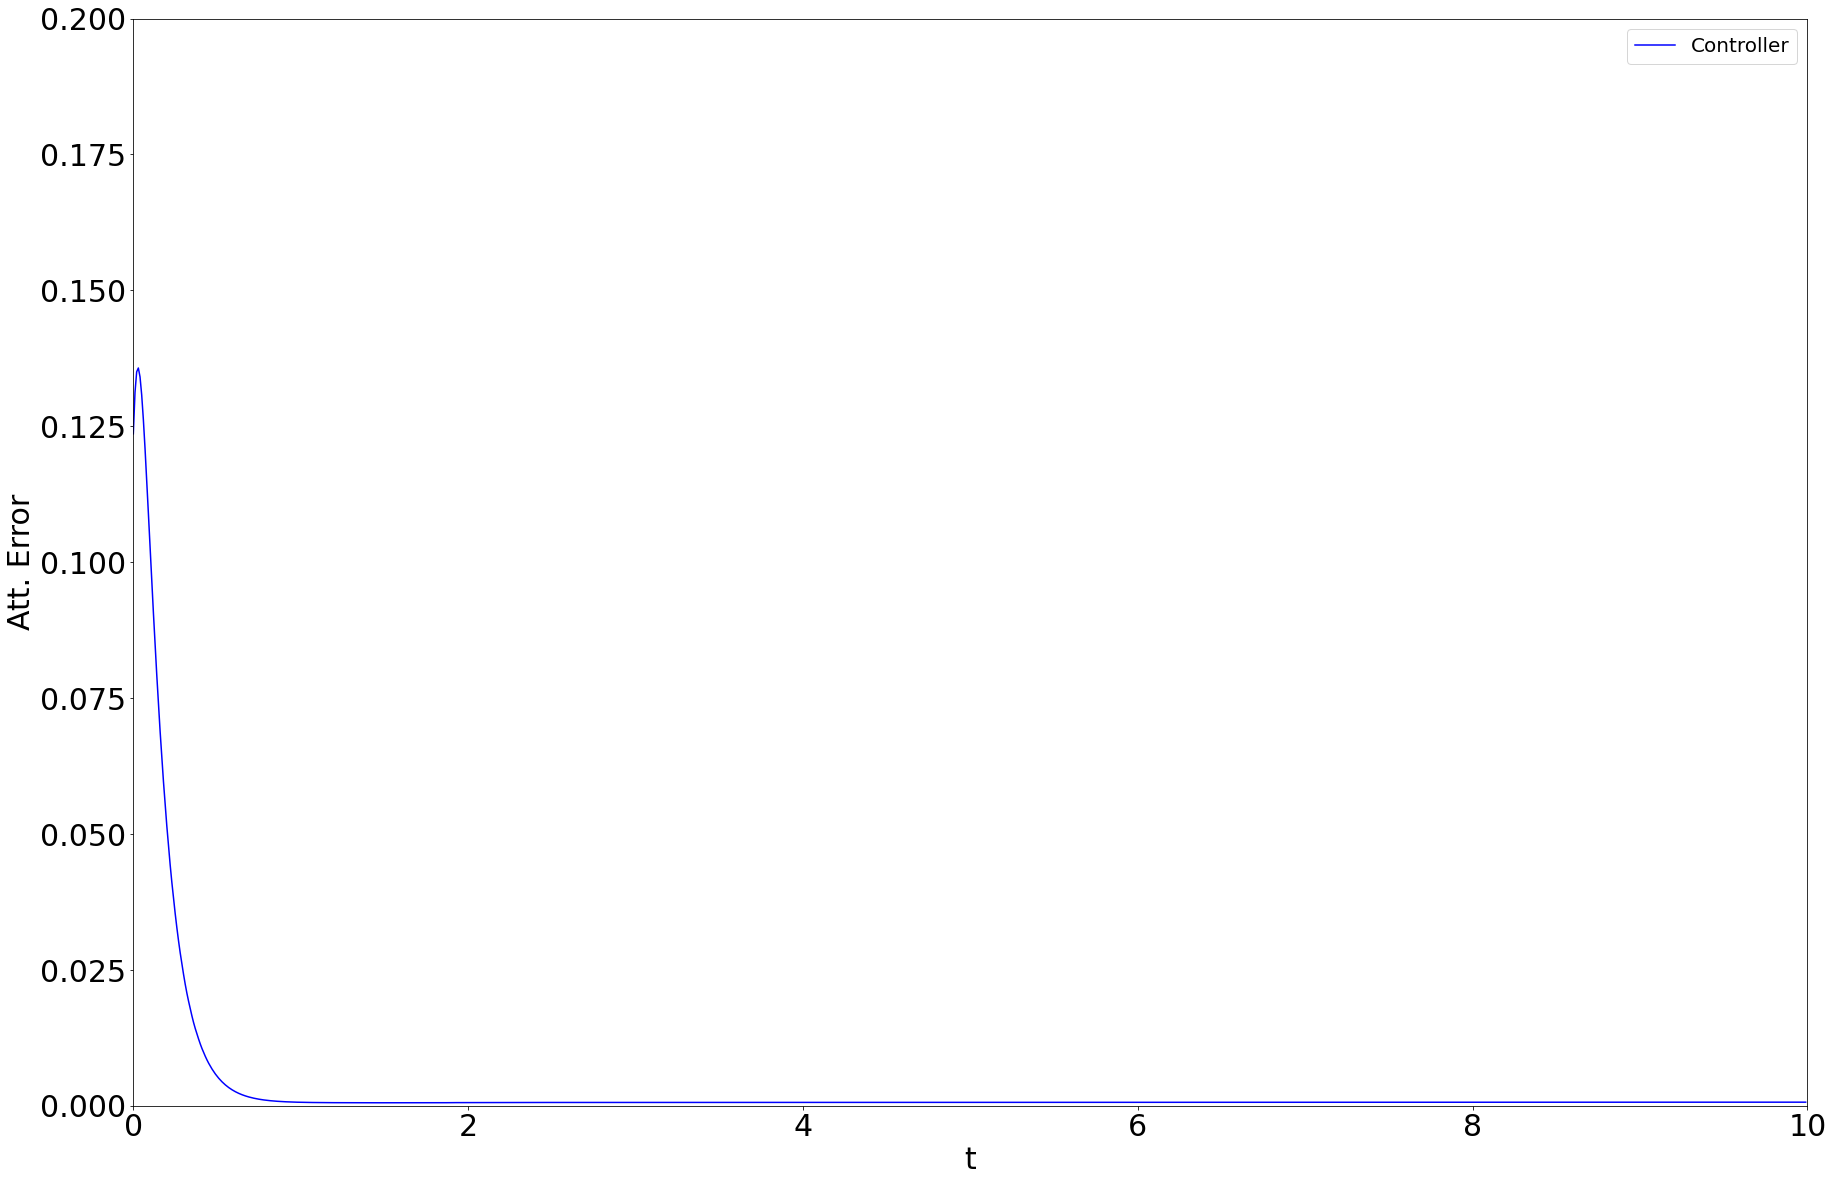

In [9]:
fig, axs = plt.subplots(4, 1,figsize = (12*2.5,8*2.5))

lim = [0, end]

plt.rcParams['font.size'] = '30'

axs[0].plot(tcase1,T1, 'b',label='Controller')
axs[0].set_xlabel('t')
axs[0].set_ylabel('Thrust1')
axs[0].set_xlim(lim)
axs[0].legend(fontsize=20)



axs[1].plot(tcase1,T2, 'b',label='Controller')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Thrust2')
axs[1].set_xlim(lim)
axs[1].legend(fontsize=20)


axs[2].plot(tcase1,T3, 'b',label='Controller')
axs[2].set_xlabel('t')
axs[2].set_ylabel('Thrust3')
axs[2].set_xlim(lim)
axs[2].legend(fontsize=20)

axs[3].plot(tcase1,T4, 'b',label='Controller')
axs[3].set_xlabel('t')
axs[3].set_ylabel('Thrust4')
axs[3].set_xlim(lim)
axs[3].legend(fontsize=20)


fig, axs = plt.subplots(1, 1,figsize = (12*2.5,8*2.5))

lim = [0, 10]

plt.rcParams['font.size'] = '30'

axs.plot(tcase1,Rc, 'b',label='Controller')
axs.set_xlabel('t')
axs.set_ylabel('Att. Error')
axs.set_xlim(lim)
axs.set_ylim([0, .2])
axs.legend(fontsize=20)

# Plotting torques (Case 1)

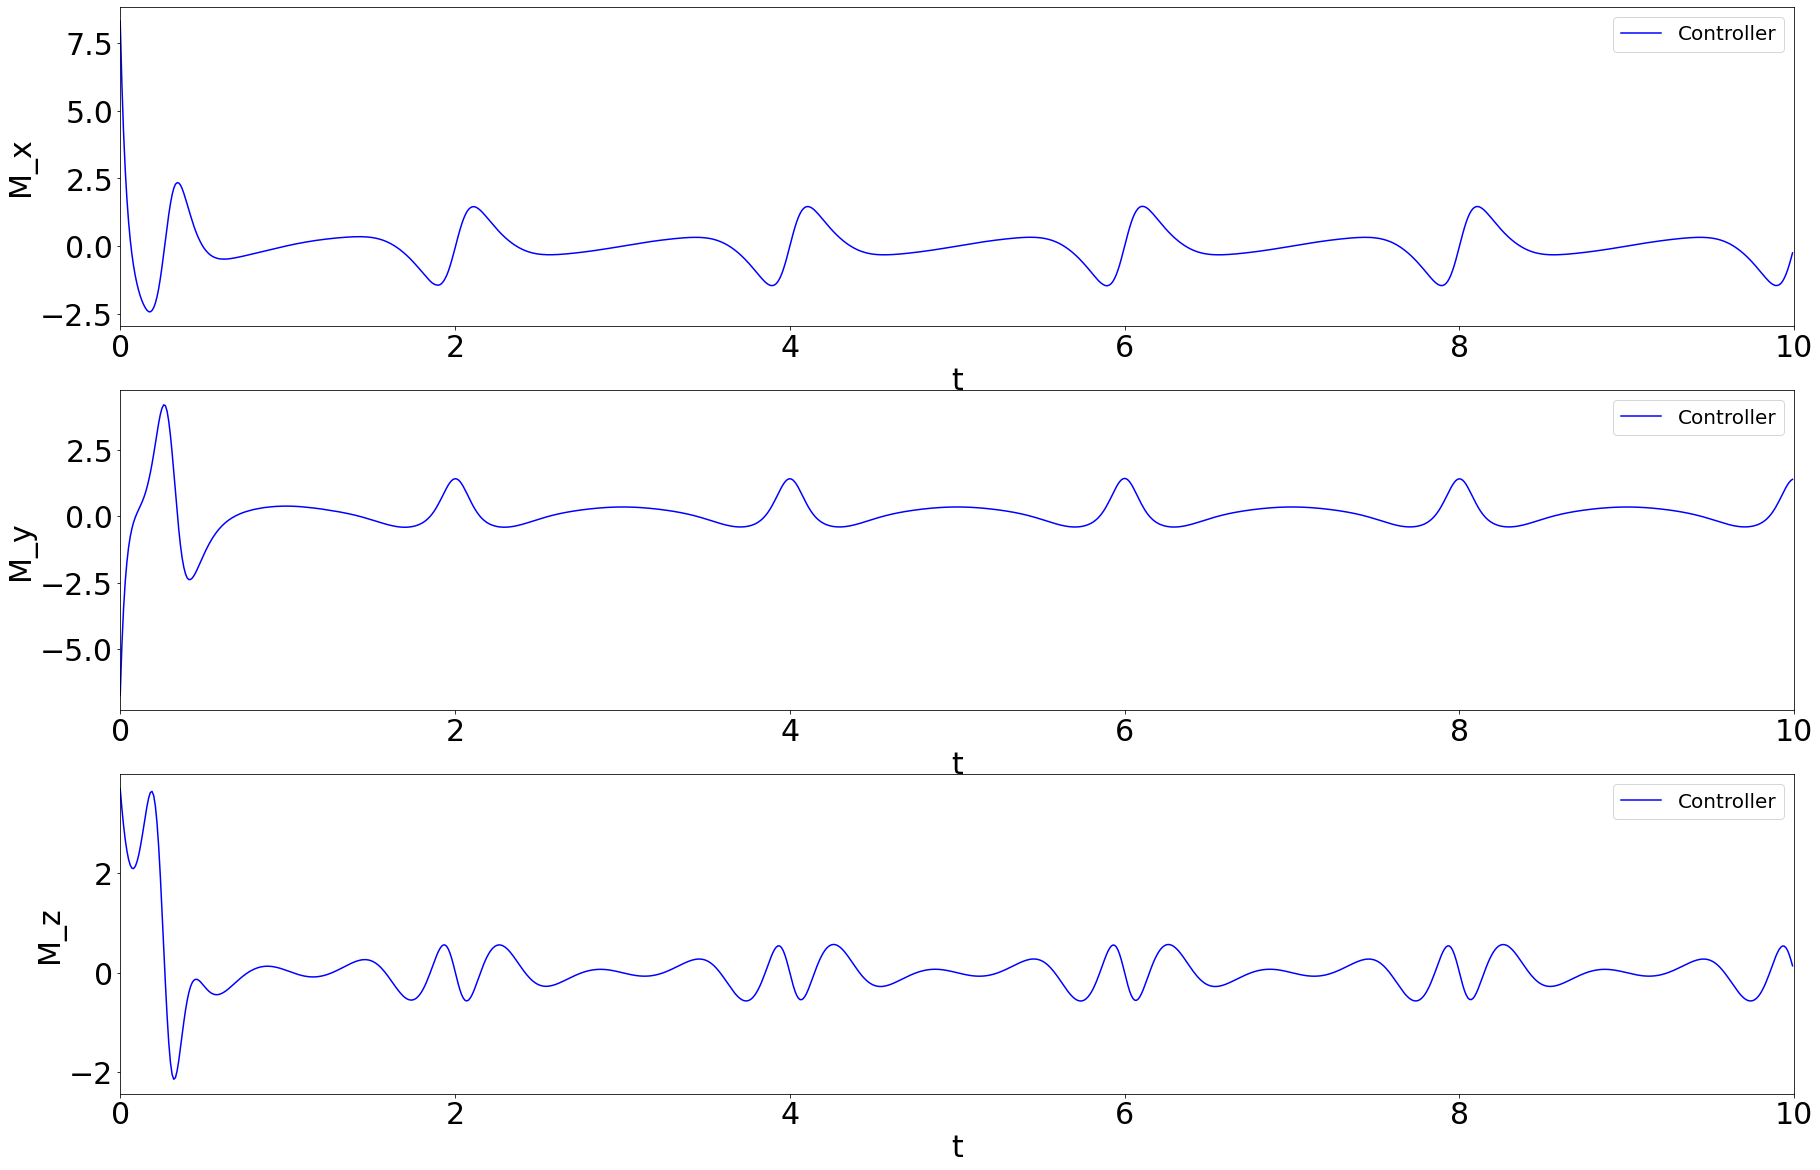

In [10]:
fig, axs = plt.subplots(3, 1,figsize = (12*2.5,8*2.5))

lim = [0, end]

plt.rcParams['font.size'] = '30'

axs[0].plot(tcase1,M1, 'b',label='Controller')
axs[0].set_xlabel('t')
axs[0].set_ylabel('M_x')
axs[0].set_xlim(lim)
axs[0].legend(fontsize=20)



axs[1].plot(tcase1,M2, 'b',label='Controller')
axs[1].set_xlabel('t')
axs[1].set_ylabel('M_y')
axs[1].set_xlim(lim)
axs[1].legend(fontsize=20)


axs[2].plot(tcase1,M3, 'b',label='Controller')
axs[2].set_xlabel('t')
axs[2].set_ylabel('M_z')
axs[2].set_xlim(lim)
axs[2].legend(fontsize=20)

# Solving ODE of the UAV motion (Case 2)

In [11]:
# Setting disturbance force to Zero

C_d = 0

# Desired Trajectory

def x_d(t):
    return np.array([0., 0, 0])

def xdot_d(t):
    return np.array([0., 0, 0])

def xdot2_d(t):
    return np.array([0., 0, 0])

def xdot3_d(t):
    return np.array([0., 0, 0])

def xdot4_d(t):
    return np.array([0., 0, 0])


def b_1d(t):
    return np.array([1, 0., 0])

def bdot_1d(t):
    return np.array([0., 0, 0])

def bdot2_1d(t):
    return np.array([0., 0, 0])


# Initial Conditions
x0 = [0, 0., 0] # Initial Position
v0 = [0, 0., 0]  # Initial Velocity
R0 = np.array([[1, 0, 0],
               [0, -0.9995, -0.0314],
               [0, 0.0314, -0.9995]])   # Initial Rotation Matrix
omega0 = [0, 0., 0]  # Initial Angular Velocity

y0 = [x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], 
 R0[0,0], R0[1,0],R0[2,0],R0[0,1],R0[1,1],R0[2,1],R0[0,2],R0[1,2],R0[2,2],omega0[0],omega0[1],omega0[2]]

t_span = (0.0, 6)     # Duration: 0 to 6S
tcase2 = np.arange(0.0, 6, 0.01)

# Numerical Solution

case2 = solve_ivp(Quadrotor, t_span, y0, t_eval=tcase2)

# Extracting trusts, attitude error, torques, force, desired omega (Case 2)

In [12]:
history2 = []
for i in range(len(tcase2)):
    (t, *s) = np.concatenate((tcase2.reshape((1,-1)), case2.y), axis=0)[:,i]
    history2.append(fgen(t,s))

In [13]:
history2 = np.array(history2)
T12 = history2[:,0]
T22 = history2[:,1]
T32 = history2[:,2]
T42 = history2[:,3]
f2 = history2[:,4]
M12 = history2[:,5]
M22 = history2[:,6]
M32 = history2[:,7]
omegax2 = history2[:,8]
omegay2 = history2[:,9]
omegaz2 = history2[:,10]
Rc2 = history2[:,11]

# Plotting position and angular velocity (Case 2)

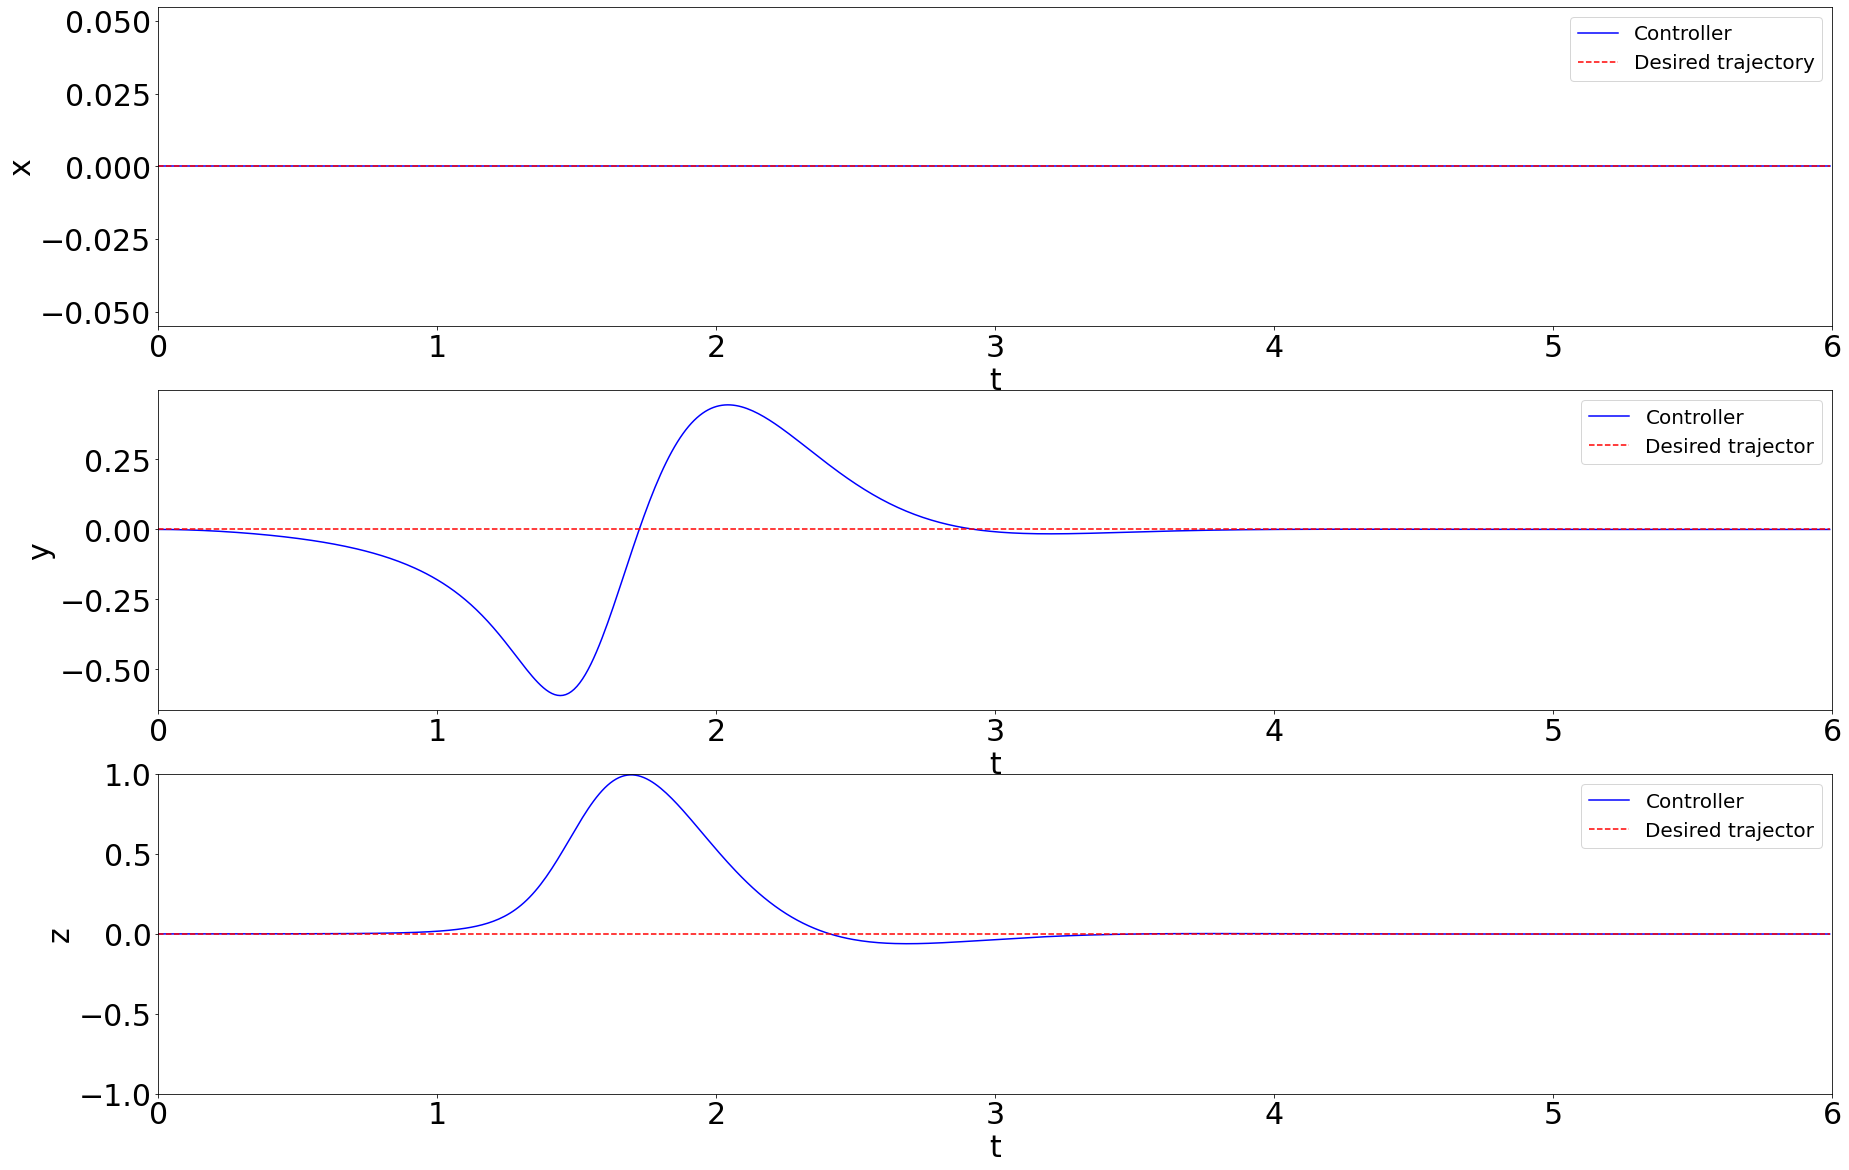

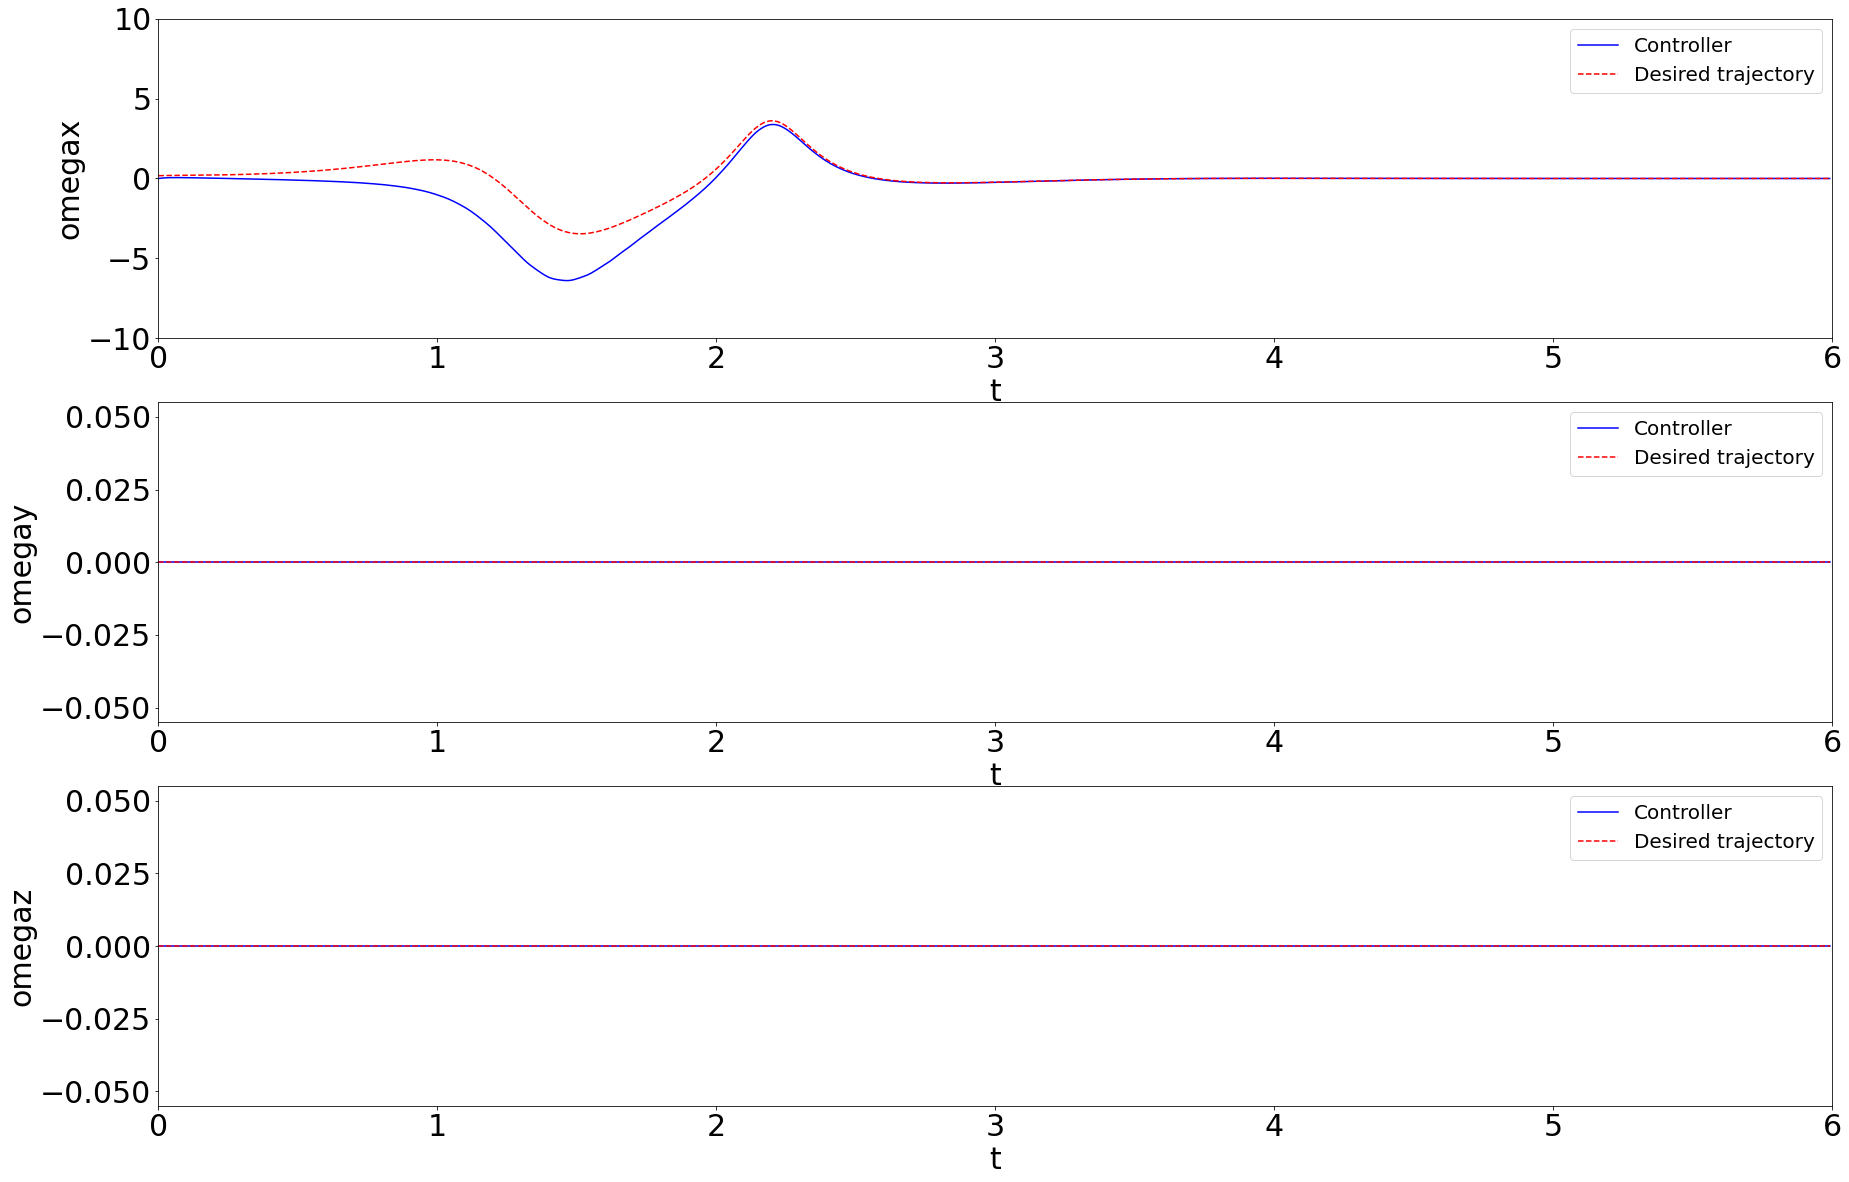

In [14]:
fig, axs = plt.subplots(3, 1,figsize = (12*2.5,8*2.5))

lim = [0, 6]



plt.rcParams['font.size'] = '30'

axs[0].plot(tcase2,case2.y[0, :], 'b',label='Controller')
axs[0].plot(tcase2,np.zeros(tcase2.shape), 'r--',label='Desired trajectory')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_xlim(lim)
axs[0].legend(fontsize=20)



axs[1].plot(tcase2,case2.y[1, :], 'b',label='Controller')
axs[1].plot(tcase2,np.zeros(tcase2.shape), 'r--',label='Desired trajector')
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')
axs[1].set_xlim(lim)
axs[1].legend(fontsize=20)


axs[2].plot(tcase2,case2.y[2, :], 'b',label='Controller')
axs[2].plot(tcase2,np.zeros(tcase2.shape), 'r--',label='Desired trajector')
axs[2].set_xlabel('t')
axs[2].set_ylabel('z')
axs[2].set_xlim(lim)
axs[2].set_ylim([-1,1])
axs[2].legend(fontsize=20)


fig, axs = plt.subplots(3, 1,figsize = (12*2.5,8*2.5))

lim = [0, 6]

plt.rcParams['font.size'] = '30'

axs[0].plot(tcase2,case2.y[15, :], 'b',label='Controller')
axs[0].plot(tcase2,omegax2, 'r--', label='Desired trajectory')
axs[0].set_xlabel('t')
axs[0].set_ylabel('omegax')
axs[0].set_xlim(lim)
axs[0].set_ylim([-10,10])
axs[0].legend(fontsize=20)



axs[1].plot(tcase2,case2.y[16, :], 'b',label='Controller')
axs[1].plot(tcase2,omegay2, 'r--', label='Desired trajectory')
axs[1].set_xlabel('t')
axs[1].set_ylabel('omegay')
axs[1].set_xlim(lim)
axs[1].legend(fontsize=20)


axs[2].plot(tcase2,case2.y[17, :], 'b',label='Controller')
axs[2].plot(tcase2,omegaz2, 'r--', label='Desired trajectory')
axs[2].set_xlabel('t')
axs[2].set_ylabel('omegaz')
axs[2].set_xlim(lim)
axs[2].legend(fontsize=20)

# Plotting trusts and attitude error (Case 2)

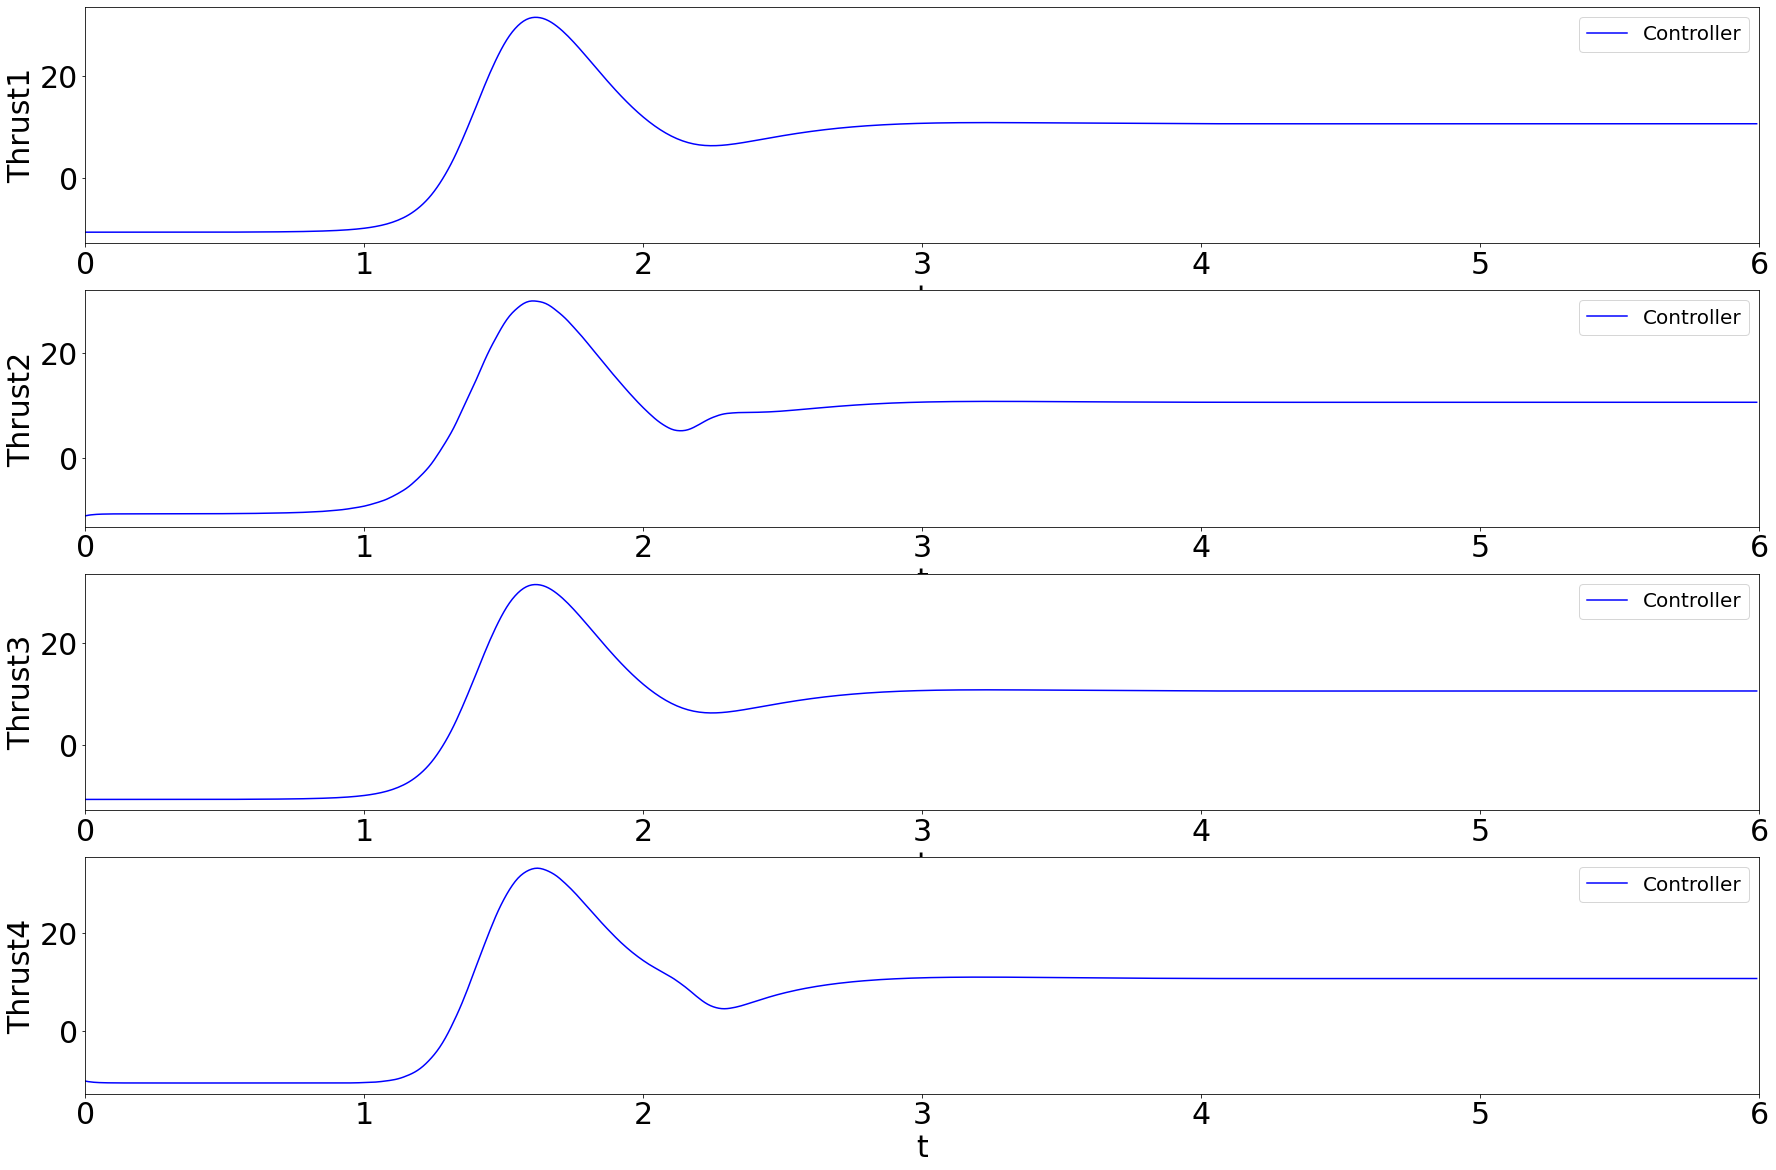

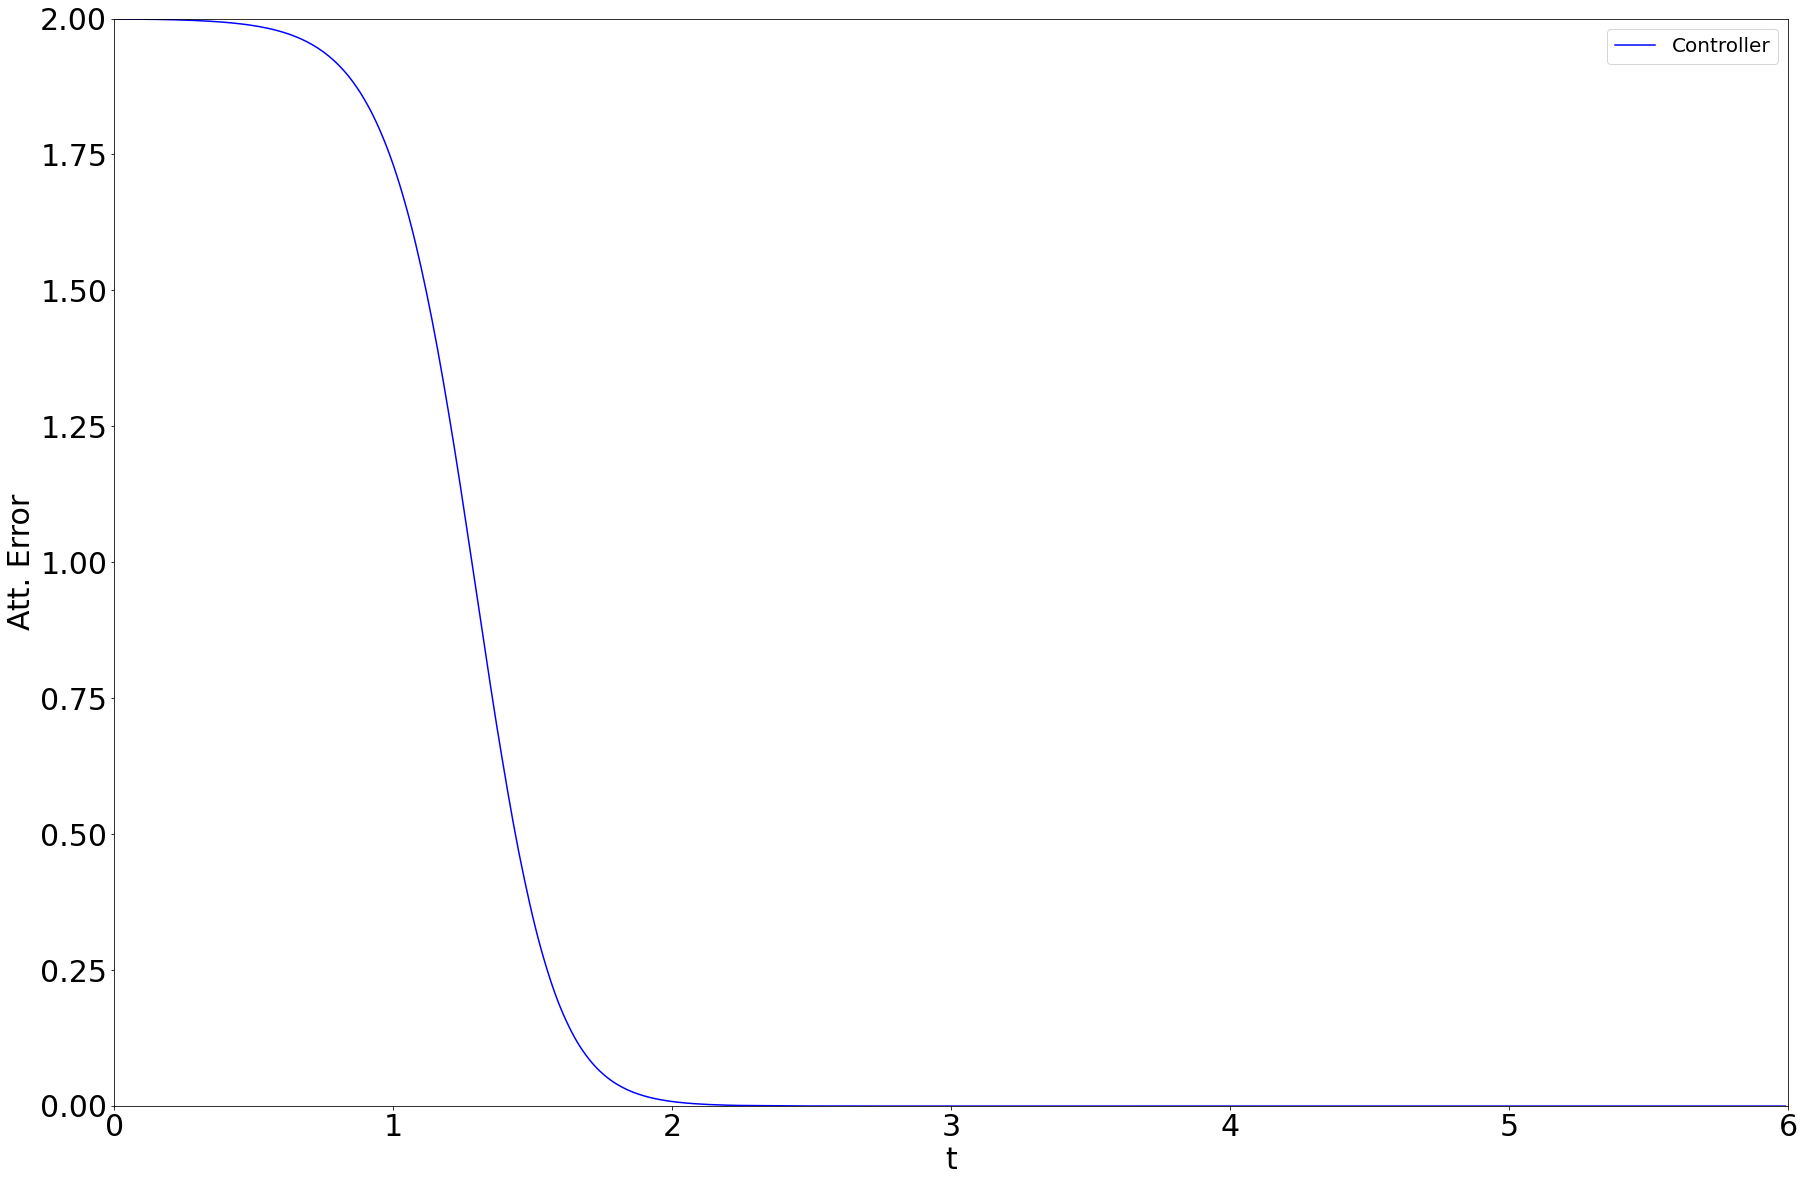

In [15]:
fig, axs = plt.subplots(4, 1,figsize = (12*2.5,8*2.5))

lim = [0, 6]

plt.rcParams['font.size'] = '30'

axs[0].plot(tcase2,T12, 'b',label='Controller')
axs[0].set_xlabel('t')
axs[0].set_ylabel('Thrust1')
axs[0].set_xlim(lim)
axs[0].legend(fontsize=20)



axs[1].plot(tcase2,T22, 'b',label='Controller')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Thrust2')
axs[1].set_xlim(lim)
axs[1].legend(fontsize=20)


axs[2].plot(tcase2,T32, 'b',label='Controller')
axs[2].set_xlabel('t')
axs[2].set_ylabel('Thrust3')
axs[2].set_xlim(lim)
axs[2].legend(fontsize=20)

axs[3].plot(tcase2,T42, 'b',label='Controller')
axs[3].set_xlabel('t')
axs[3].set_ylabel('Thrust4')
axs[3].set_xlim(lim)
axs[3].legend(fontsize=20)


fig, axs = plt.subplots(1, 1,figsize = (12*2.5,8*2.5))

lim = [0, 6]

plt.rcParams['font.size'] = '30'

axs.plot(tcase2,Rc2, 'b',label='Controller')
axs.set_xlabel('t')
axs.set_ylabel('Att. Error')
axs.set_xlim(lim)
axs.set_ylim([0, 2])
axs.legend(fontsize=20)